<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Цели исследования

Построить модель для предсказания количества заказов такси на следующий часв период пиковой нагрузки в аэропортах.

# Описание данных

 - *'num_orders'* - Количество заказов находится в столбце  

# План работы

1. Изучить информацию о данных и произвести ресемплирование по одному часу;
2. Проанализировать данные;
3. Обучить разные модели с различными сочетаниями гиперпараметров;
4. Проверить данные на тестовой выборке.

## Подготовка

**Импортируем необходимые библиотеки вначале документа (pandas, numpy, matplotlib.pyplot и другие).**

In [1]:
import sys
!"{sys.executable}" -m pip install phik

import os

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01


In [2]:
import time
import pandas as pd
import numpy as np

# graph
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

# ML
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

**Считаем данные из csv-файла и сохраним в переменную `data`. Путь к файлу: `/datasets/taxi.csv`** 

Чтобы корректно работать с датой и временем в pandas, нужно
корректно изменить тип данных соответствующего столбца с object на
datetime64 - сделаем это с помощью параметра *parse_dates*.

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = 'C:/Users/User/Desktop/DS Python/Projects/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

**Выведем первые 5 строк датафрейма `data` на экран.**

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Выведем основную информацию о данном датафрейме с помощью метода info().**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выведем информацию о количестве пропусков по столбцам в данном датафрейме с помощью метода isna() в процентах.**|

In [6]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


**Чтобы работать с временными рядами, необходимо проверить, в
хронологическом ли порядке расположены даты и время.**

In [7]:
print('Дата и время расположены в хронологочиеском порядке:',data.index.is_monotonic)

Дата и время расположены в хронологочиеском порядке: True


**Произведем ресемплирование данных по одному часу.** Так как предсказываем количество заказов, то считаем суммы заказов за час.

In [8]:
res_hour = data.resample('1H').sum()

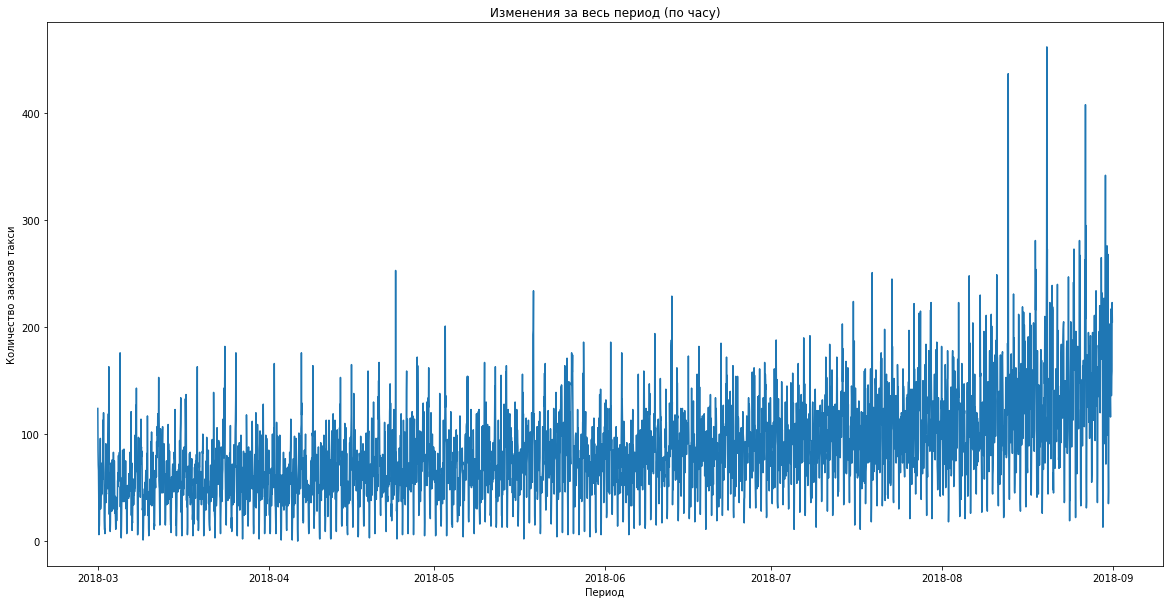

In [9]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.plot(res_hour)
plt.xlabel("Период")
plt.ylabel("Количество заказов такси")
plt.title('Изменения за весь период (по часу)')
plt.show()

По графику видно, что среднее значение данного графика меняется. То есть мы имеем дело с нестационарным временным рядом. 

Определим временной промежуток данных.

In [10]:
data.index.max() - data.index.min()

Timedelta('183 days 23:50:00')

**Вывод:**
1. Импортировали необходимые библиотеки.
2. Считали данные из csv-файла.
3. Вывели общую информацию по датафрейму: 
    - в датафрейме 2 столбца и 26.496 строк;
    - столбцы корректно названны;
    - в датасете отсутствуют пропуски;
    - общая занимаемая память 414.0 КB.
4. Произвели ресемплирование данных по одному часу.
5. Подготовились к этапу 'Анализ данных'.

## Анализ

Проанализируем данные. 

Для начала произведем ресемплирование данных по одному дню. 

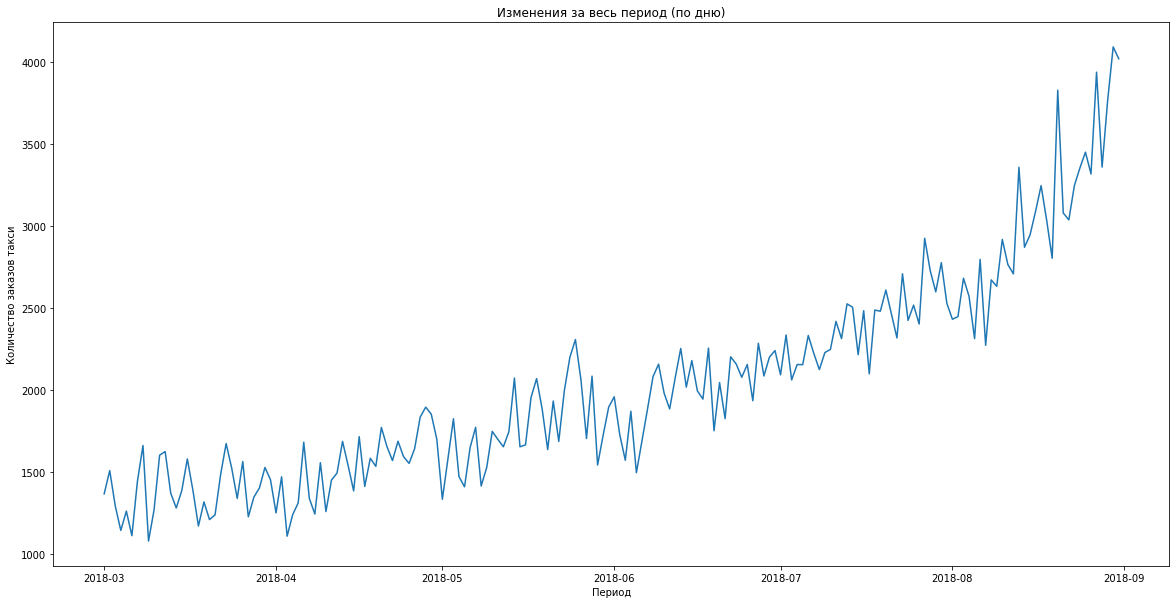

In [11]:
res_day = data.resample('1D').sum()

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.plot(res_day)
plt.xlabel("Период")
plt.ylabel("Количество заказов такси")
plt.title('Изменения за весь период (по дню)')
plt.show()

По данному графику можно сказать, что количество заказов такси растет к сентябрю, что вполне справедливо, ведь в жаркие страны люди чаще летают в августе и сентябре (скидки, конец сезона)

Далее, произведем ресемплирование данных по одному месяцу. 

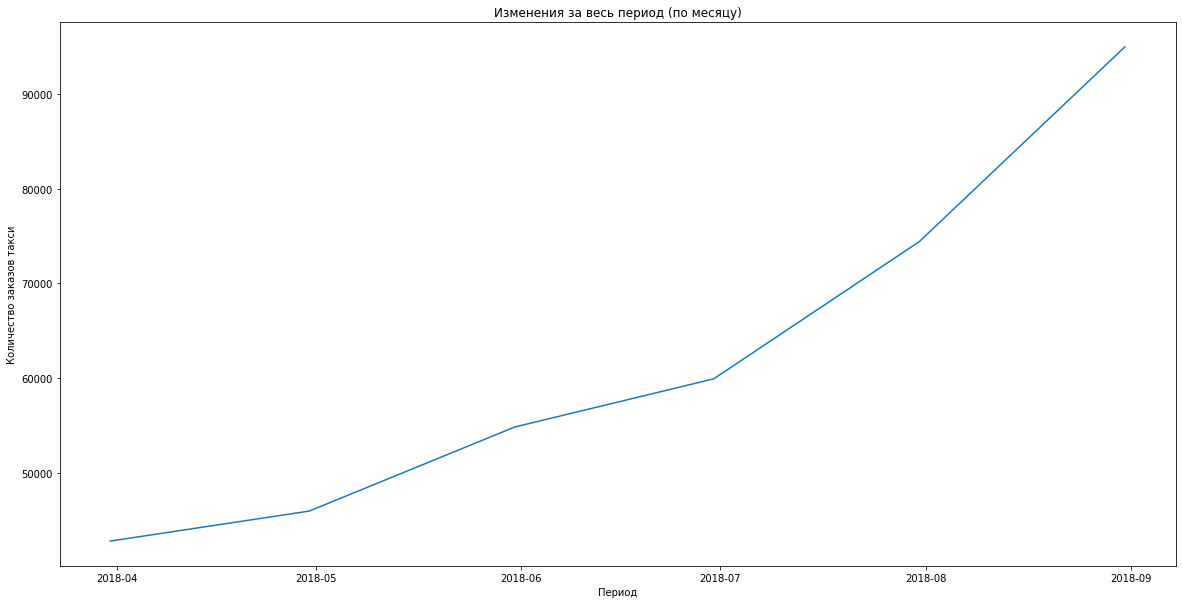

In [12]:
res_month = data.resample('1M').sum()
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.plot(res_month)
plt.xlabel("Период")
plt.ylabel("Количество заказов такси")
plt.title('Изменения за весь период (по месяцу)')
plt.show()

Предварительно по данному графику можно сказать, что есть положительный тренд, но проведем дополнительные исследования. 

**Разложим данные на тренды, сезонность и остатки.**

Для этого выделим период для более подробного изучения - месяц. 

In [13]:
data_one_month = res_hour['2018-08-01':'2018-08-31']

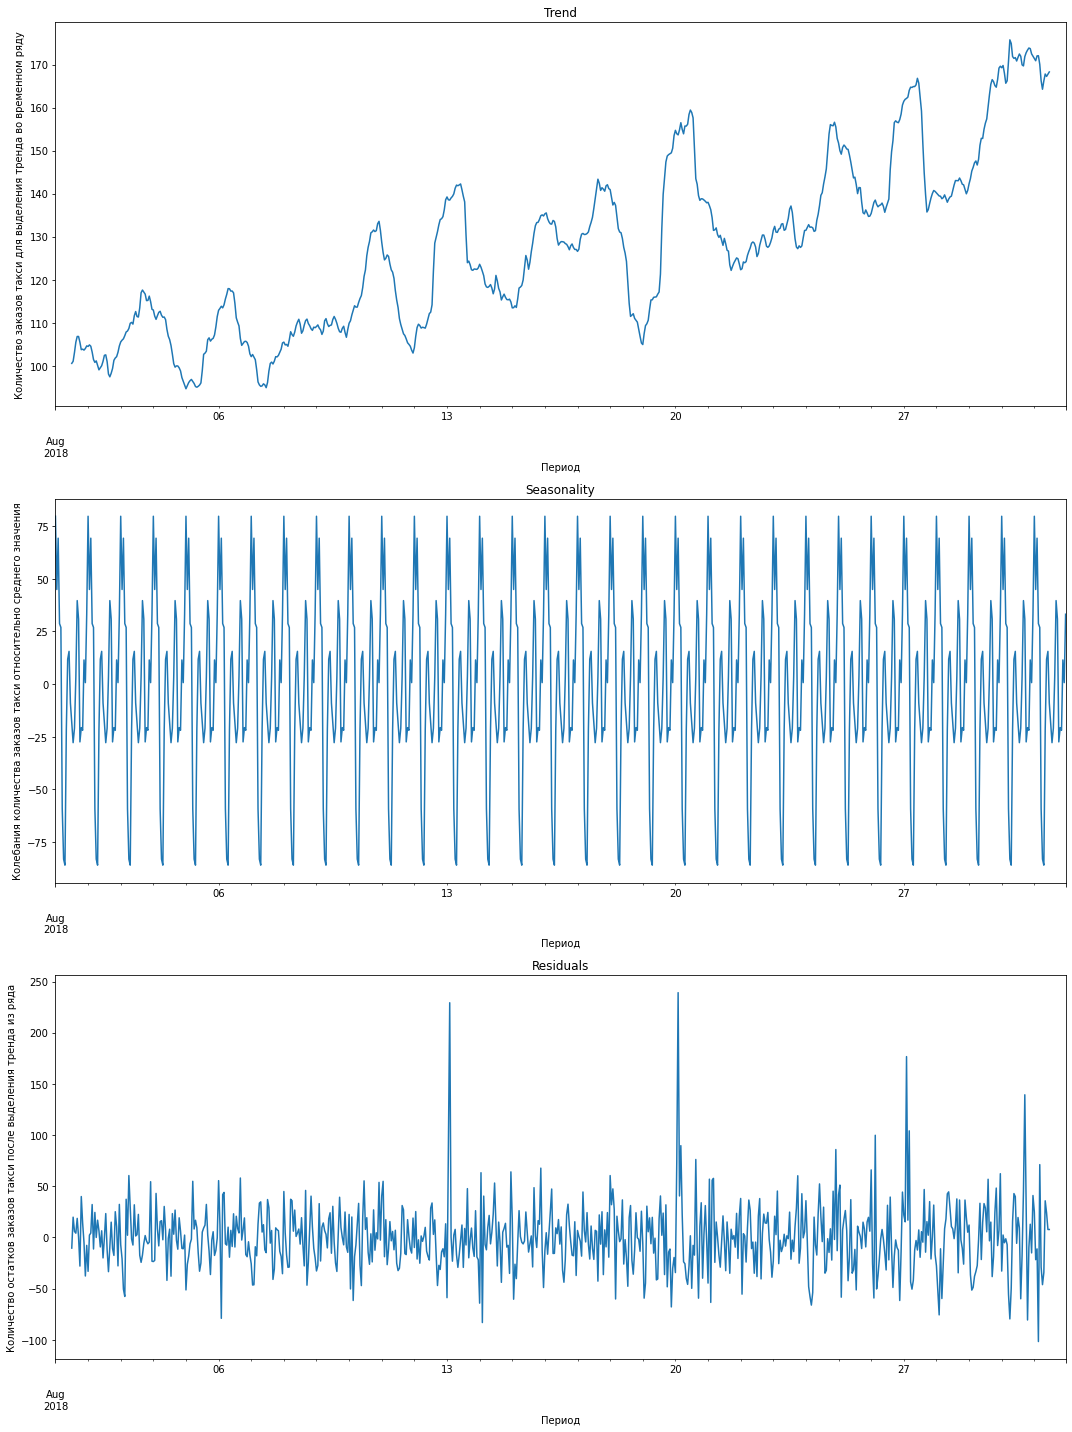

In [14]:
decomposed = seasonal_decompose(data_one_month)
plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel("Период")
plt.ylabel("Количество заказов такси для выделения тренда во временном ряду")
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel("Период")
plt.ylabel("Колебания количества заказов такси относительно среднего значения")
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel("Период")
plt.ylabel("Количество остатков заказов такси после выделения тренда из ряда")
plt.title('Residuals')

plt.tight_layout()

- На периоде месяц - можно наблюдать, что данные имеют некоторый тренд.
- Распределение сезонности - нестационарный процесс. Ночью и ранним утром такси вызывают реже, нежели под ночь. 
- Остаток тоже выглядит нестационарным, кроме некоторых всплесков на 13, 20 и 27 день. Возможно, это связано с тем, что люди в воскресенье вечером прилетают в аэропорт и хотят как можно быстрее и проще попасть домой, если понедельник уже первый рабочий день (например, после отпуска). Также люди могут улетать на небольшие путешествия, в пятницу вечером, а прилетать воскресенье вечер/ понедельник утро.

Рассмотрим сезонность дневную в период 2 недели.

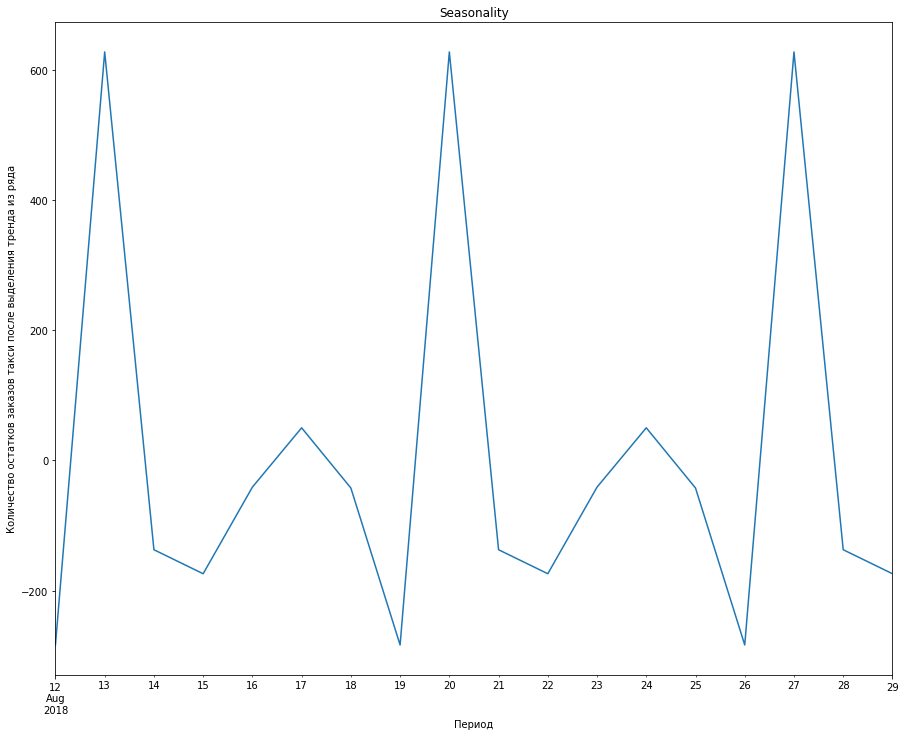

In [15]:
data_two_weeks = res_day['2018-08-12':'2018-08-29']

decomposed = seasonal_decompose(data_two_weeks)
plt.figure(figsize=(15, 12))
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel("Период")
plt.ylabel("Количество остатков заказов такси после выделения тренда из ряда")
plt.title('Seasonality');

In [16]:
res_day['weekday'] = res_day.index.dayofweek
res_day.tail(10)

,num_orders,weekday
datetime,,
2018-08-22,3035,2
2018-08-23,3244,3
2018-08-24,3352,4
2018-08-25,3448,5
2018-08-26,3315,6
2018-08-27,3936,0
2018-08-28,3357,1
2018-08-29,3762,2
2018-08-30,4090,3


In [17]:
res_day[res_day.index.dayofweek == 0].tail(3)

,num_orders,weekday
datetime,,
2018-08-13,3356,0
2018-08-20,3826,0
2018-08-27,3936,0


Оценим стационарность ряда с помощью сглаживания скользящим средним.

<AxesSubplot:xlabel='datetime'>

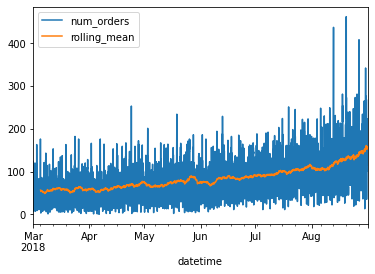

In [18]:
res_hour['rolling_mean'] = res_hour['num_orders'].rolling(100).mean()
res_hour.plot()

Оценим стационарность ряда с помощью теста Дики-Фуллера.

In [19]:
result = adfuller(res_hour['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


1. Визуально графическим способом видно, что средняя уходит вверх. - соответственно можно сделать, что процесс не стационарный. 

2. Оценка стационарности с помощью теста Дики-Фуллера в зависимости от уровня занчимости `alpha` получаются разные выводы. При `alpha`= 5% - процесс можно считать стационарным. Но при более жестких условиях `alpha`= 1% - временной ряд не стационарен. 

**Вывод:**

1. Если опираться на данные, можно сделать вывод, что есть тренд, но для более точного ответа на этот вопрос нужны данные за год, как минимум. 
2. Есть сезонность по часам. Ночью и ранним утром такси вызывают реже, нежели под ночь. 
3. Есть сезонность по дням недели. Чаще всего такси вызывают в понедельник. 

## Обучение

**Обучим и сравним следующие модели: LinearRegression, RandomForestRegressor, LGBMRegressor**

Все результаты сохраним в словаре.

In [20]:
total = {}

Спрогнозируем данные значения без обучения:
    
**Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)**

In [23]:
train, test = train_test_split(res_hour, shuffle=False, test_size=0.1)

pred_previous = test['num_orders'].shift(periods=1, 
                                fill_value=train['num_orders'].iloc[-1])
print("RMSE:", mean_squared_error(test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


In [24]:
total['pred_previous'] = ['NaN']
total['pred_previous'].append(mean_squared_error(test['num_orders'], pred_previous)**0.5)
pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous
RMSE_train,NaN
RMSE_test,58.856486


**Все значения тестовой выборки предсказываются одним и тем же числом (константой)**

In [25]:
pred_median = np.ones(test.shape[0]) * train['num_orders'].median()
print("RMSE:", mean_squared_error(test['num_orders'], pred_median)**0.5)

RMSE: 87.15277582981295


In [26]:
total['pred_median'] = ['NaN']
total['pred_median'].append(mean_squared_error(test['num_orders'], pred_median)**0.5)
pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous,pred_median
RMSE_train,NaN,NaN
RMSE_test,58.856486,87.152776


Предсказания по предыдущим значениям оказались наиболее точными. Возьмем эту метрику для оценки результатов.

Напишем функцию для создания обучающих признаков.

In [27]:
def make_features(data_feat, max_lag, rolling_mean_size):
    data_feat = res_hour.copy()
    
    # Календарные признаки
    #data_feat['year'] = data_feat.index.year
    #data_feat['month'] = data_feat.index.month
    data_feat['day'] = data_feat.index.day
    data_feat['dayofweek'] = data_feat.index.dayofweek
    
    # Отстающие значения    
    for lag in range(1, max_lag + 1):
        data_feat['lag_{}'.format(lag)] = data_feat['num_orders'].shift(lag)

    # Скользящее среднее
    data_feat['rolling_mean'] = data_feat['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_feat = data_feat.dropna()
    
    return data_feat

**Подготовим данные к обучению и разделим в соотношении 9:1.**

In [28]:
data_new = make_features(res_hour, 8, 5)

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [29]:
features_train.head()

,rolling_mean,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
datetime,,,,,,,,,,,
2018-03-01 08:00:00,28.4,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 09:00:00,22.0,1,3,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 10:00:00,27.2,1,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 11:00:00,38.8,1,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 12:00:00,55.6,1,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


### Модель LinearRegression

Построим модель LinearRegression и посчитаем значение метрики RMSE на тестовой и обучающей выборке.

In [30]:
linreg_param = {
    'n_jobs': range(1, 20)
}

tscv = TimeSeriesSplit(n_splits=5)
rsc_linreg = RandomizedSearchCV(LinearRegression(), 
                                param_distributions=linreg_param, 
                                scoring='neg_root_mean_squared_error',
                                cv=tscv)
rsc_linreg = rsc_linreg.fit(features_train, target_train)

print('Лучшие параметры для модели RandomForestRegressor:', rsc_linreg.best_params_)
print("RMSE с лучшими параметрами:", abs(rsc_linreg.best_score_))

Лучшие параметры для модели RandomForestRegressor: {'n_jobs': 2}
RMSE с лучшими параметрами: 32.82234418041003


Запишем полученные данные в таблицу.

In [31]:
total['LinearRegression'] = [abs(rsc_linreg.best_score_)]
total['LinearRegression'].append("NaN")

pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous,pred_median,LinearRegression
RMSE_train,NaN,NaN,32.822344
RMSE_test,58.856486,87.152776,NaN


### Модель RandomForestRegressor

Построим модель RandomForestRegressor и посчитаем значение метрики RMSE на тестовой и обучающей выборке.

In [32]:
forest_param = {
    'n_estimators': range(1,51,10),
    'min_samples_leaf': range(2,5),
    'min_samples_split': range(2,5),
    'max_depth': range(1,10)
}

tscv = TimeSeriesSplit(n_splits=5)
rsc_forest = RandomizedSearchCV(RandomForestRegressor(random_state = 123), 
                                param_distributions=forest_param, 
                                scoring='neg_root_mean_squared_error', 
                                cv=tscv)
rsc_forest = rsc_forest.fit(features_train, target_train)

print('Лучшие параметры для модели RandomForestRegressor:', rsc_forest.best_params_)
print("RMSE с лучшими параметрами:", abs(rsc_forest.best_score_))

Лучшие параметры для модели RandomForestRegressor: {'n_estimators': 41, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 9}
RMSE с лучшими параметрами: 31.014600142327872


Запишем полученные данные в таблицу.

In [33]:
total['RandomForestRegressor'] = [abs(rsc_forest.best_score_)]
total['RandomForestRegressor'].append("NaN")

pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous,pred_median,LinearRegression,RandomForestRegressor
RMSE_train,NaN,NaN,32.822344,31.0146
RMSE_test,58.856486,87.152776,NaN,NaN


### Модель LGBMRegressor

Построим модель LGBMRegressor и посчитаем значение метрики RMSE на тестовой и обучающей выборке.

In [34]:
params = {
    'learning_rate': [0.1, 0.4],
    'max_depth': [3, 16, 3],
    'num_leaves': [10, 30, 10],
}

tscv = TimeSeriesSplit(n_splits=5)
rsc_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=333),
                              param_distributions=params,
                              cv=tscv,
                              scoring='neg_root_mean_squared_error',
                              verbose=False)

rsc_lgbm.fit(features_train, target_train)

print('Лучшие параметры для модели LGBMRegressor:', rsc_lgbm.best_params_)
print("RMSE с лучшими параметрами:", abs(rsc_lgbm.best_score_))

Лучшие параметры для модели LGBMRegressor: {'num_leaves': 10, 'max_depth': 3, 'learning_rate': 0.1}
RMSE с лучшими параметрами: 31.517008532570106


Запишем полученные данные в таблицу.

In [35]:
total['LGBMRegressor'] = [abs(rsc_lgbm.best_score_)]
total['LGBMRegressor'].append("NaN")

pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous,pred_median,LinearRegression,RandomForestRegressor,LGBMRegressor
RMSE_train,NaN,NaN,32.822344,31.0146,31.517009
RMSE_test,58.856486,87.152776,NaN,NaN,NaN


**Вывод:**

Лучшие значения метрики RMSE показала модель RandomForestRegressor. 

Оценим на тестовой выборке значение метрики для этой модели. 

## Тестирование

In [36]:
pd.DataFrame(total, index=['RMSE_train', 'RMSE_test'])

,pred_previous,pred_median,LinearRegression,RandomForestRegressor,LGBMRegressor
RMSE_train,NaN,NaN,32.822344,31.0146,31.517009
RMSE_test,58.856486,87.152776,NaN,NaN,NaN


На тестовых выборках модели были проверены в предыдущем пункте. 
Как видно из таблицы лучшие предсказания получились на модели `RandomForestRegressor`.
Для лучшей модели визуализируем предсказания в виде графика. 

In [37]:
# построение модели

model_forest = RandomForestRegressor(random_state = 123, n_estimators=31, 
                                     min_samples_leaf=2, min_samples_split=4, 
                                     max_depth=8)
model_forest.fit(features_train, target_train)

pred_forest_test = model_forest.predict(features_test)

print("RMSE тестовой выборки:", mean_squared_error(target_test, pred_forest_test)**0.5)

RMSE тестовой выборки: 55.25467320975628


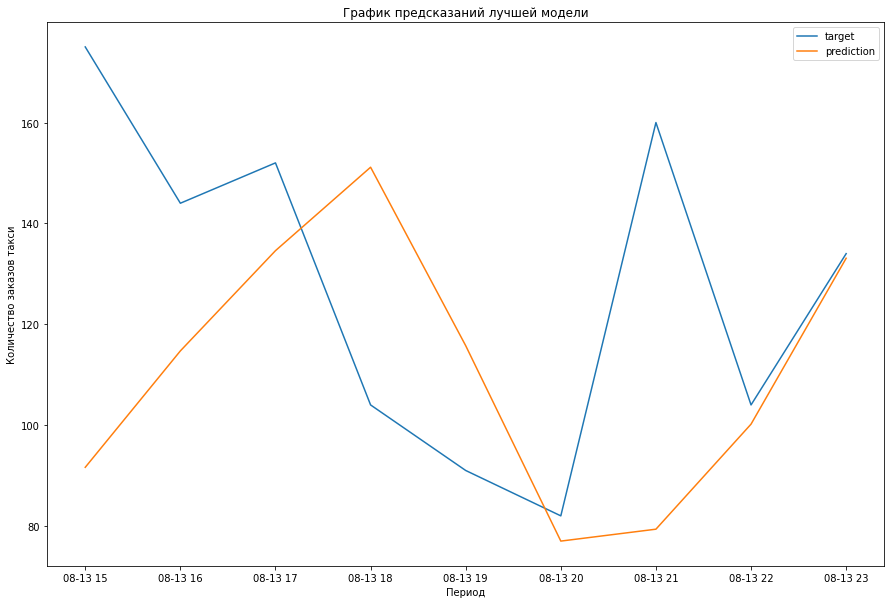

In [38]:
pred_total = pd.DataFrame(target_test, index=test.index)
pred_total['prediction'] = pred_forest_test 

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax = plt.plot(pred_total[
    '2018-08-13':'2018-08-13'])
plt.legend(ax, ['target', 'prediction'])
plt.xlabel("Период")
plt.ylabel("Количество заказов такси")
plt.title('График предсказаний лучшей модели')
plt.show()

## Общий вывод

1. Импортировали необходимые библиотеки и считали данные из csv-файла.
2. Вывели общую информацию по датафрейму: 
    - в датафрейме 2 столбца и 26.496 строк;
    - столбцы корректно названны;
    - в датасете отсутствуют пропуски;
    - общая занимаемая память 414.0 КB.
3. Произвели ресемплирование данных по одному часу.
4. Для того, чтобы точно утверждать есть ли тренд в данных, нужно большее количество данных (минимум за год). 
5. В данных есть сезонность по часам (пик - вечер) и по дням недели (пик - понедельник)
6. Наилучшая модель `RandomForestRegressor` со значением RMSE тестовой выборки: 55.25. 
7. Все остальные модели оказались лучше модели предсказания по предыдущим значениям, кроме модели предсказания по медиане (константная модель). 